(blackbox_external_likelihood_numpy)=
# Using a "black box" likelihood function (numpy)

:::{post} Dec 16, 2021
:tags: case study, external likelihood, 
:category: beginner
:author: Matt Pitkin, Jørgen Midtbø, Oriol Abril
:::

:::{note}
This notebook in part of a set of two twin notebooks that perform the exact same task, this one
uses numpy whereas {ref}`this other one <blackbox_external_likelihood>` uses Cython
:::

In [1]:
import arviz as az
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
from testclass import Canonical

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.9.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

## Introduction
[PyMC](https://docs.pymc.io) is a great tool for doing Bayesian inference and parameter estimation. It has a load of {doc}`in-built probability distributions <pymc:api/distributions>` that you can use to set up priors and likelihood functions for your particular model. You can even create your own {ref}`custom distributions <custom_distribution>`.

However, this is not necessarily that simple if you have a model function, or probability distribution, that, for example, relies on an external code that you have little/no control over (and may even be, for example, wrapped `C` code rather than Python). This can be problematic when you need to pass parameters as PyMC distributions to these external functions; your external function probably wants you to pass it floating point numbers rather than PyMC distributions!

```python
import pymc as pm
from external_module import my_external_func  # your external function!

# set up your model
with pm.Model():
    # your external function takes two parameters, a and b, with Uniform priors
    a = pm.Uniform('a', lower=0., upper=1.)
    b = pm.Uniform('b', lower=0., upper=1.)
    
    m = my_external_func(a, b)  # <--- this is not going to work!
```

Another issue is that if you want to be able to use the gradient-based step samplers like {class}`pymc.NUTS` and {class}`Hamiltonian Monte Carlo (HMC) <pymc.HamiltonianMC>`, then your model/likelihood needs a gradient to be defined. If you have a model that is defined as a set of PyTensor operators then this is no problem - internally it will be able to do automatic differentiation - but if your model is essentially a "black box" then you won't necessarily know what the gradients are.

Defining a model/likelihood that PyMC can use and that calls your "black box" function is possible, but it relies on creating a [custom PyTensor Op](https://docs.pymc.io/advanced_pytensor.html#writing-custom-pytensor-ops). This is, hopefully, a clear description of how to do this, including one way of writing a gradient function that could be generally applicable.

In the examples below, we create a very simple model and log-likelihood function in numpy.

In [3]:
def my_model(theta, x):
    m, c = theta
    return m * x + c

def my_model2(theta):
    nC=3
    nO=2
    a,b,c,d,e,f,g,h = theta
    myCano = Canonical(nC,nO)
    return myCano.do_perm(a,b,c,d,e,f,g,h)

def my_loglike(theta):
    #model = my_model(theta, x)
    return my_model2(theta)
    #return -(0.5 / sigma**2) * np.sum((data - model) ** 2)

Now, as things are, if we wanted to sample from this log-likelihood function, using certain prior distributions for the model parameters (gradient and y-intercept) using PyMC, we might try something like this (using a {class}`pymc.DensityDist` or {class}`pymc.Potential`):

```python
import pymc as pm

# create/read in our "data" (I'll show this in the real example below)
x = ...
sigma = ...
data = ...

with pm.Model():
    # set priors on model gradient and y-intercept
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create custom distribution 
    pm.DensityDist('likelihood', my_loglike,
                   observed={'theta': (m, c), 'x': x, 'data': data, 'sigma': sigma})
    
    # sample from the distribution
    trace = pm.sample(1000)
```

But, this will give an error like:

```
ValueError: setting an array element with a sequence.
```

This is because `m` and `c` are PyTensor tensor-type objects.

So, what we actually need to do is create a [PyTensor Op](http://deeplearning.net/software/pytensor/extending/extending_pytensor.html). This will be a new class that wraps our log-likelihood function (or just our model function, if that is all that is required) into something that can take in PyTensor tensor objects, but internally can cast them as floating point values that can be passed to our log-likelihood function. We will do this below, initially without defining a [grad() method](http://deeplearning.net/software/pytensor/extending/op.html#grad) for the Op.

## PyTensor Op without grad

In [4]:
# define a pytensor Op for our likelihood function
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

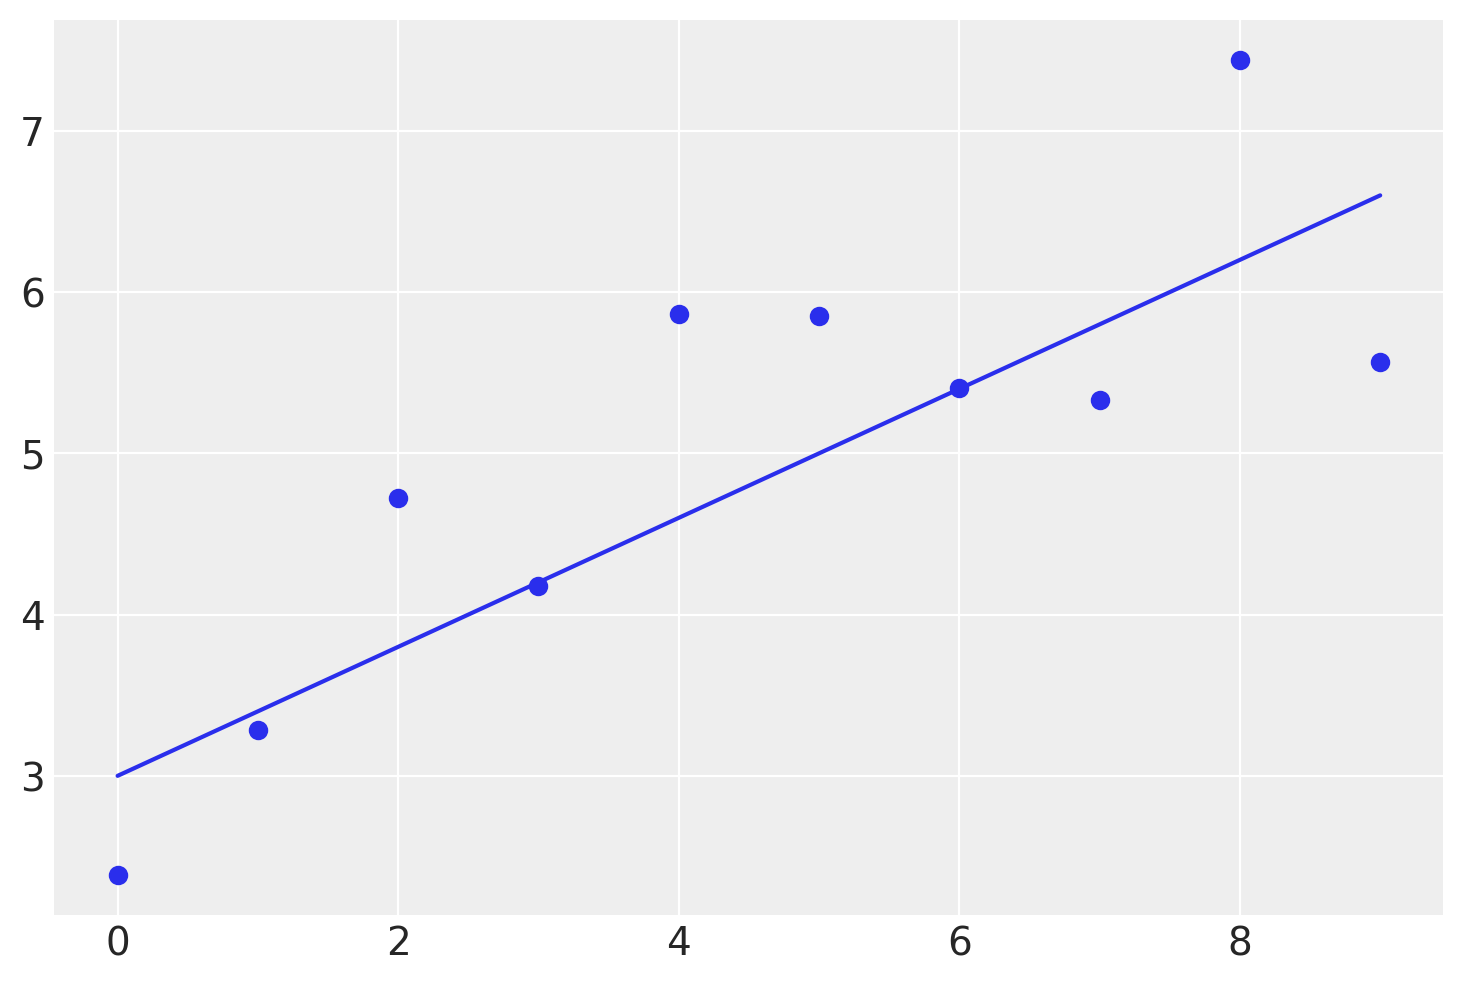

In [5]:
# set up our data
N = 10  # number of data points
sigma = 1.0  # standard deviation of noise
x = np.linspace(0.0, 9.0, N)

mtrue = 0.4  # true gradient
ctrue = 3.0  # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
rng = np.random.default_rng(716743)
data = sigma * rng.normal(size=N) + truemodel

plt.scatter(x,data)
plt.plot(x,truemodel)

Now, let's use this Op to repeat the example shown above. To do this let's create some data containing a straight line with additive Gaussian noise (with a mean of zero and a standard deviation of `sigma`). For simplicity we set {class}`~pymc.Uniform` prior distributions on the gradient and y-intercept. As we've not set the `grad()` method of the Op PyMC will not be able to use the gradient-based samplers, so will fall back to using the {class}`pymc.Slice` sampler.

Only 300 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [a]
>Slice: [b]
>Slice: [c]
>Slice: [d]
>Slice: [e]
>Slice: [f]
>Slice: [g]
>Slice: [h]


Sampling 2 chains for 100 tune and 300 draw iterations (200 + 600 draws total) took 65 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


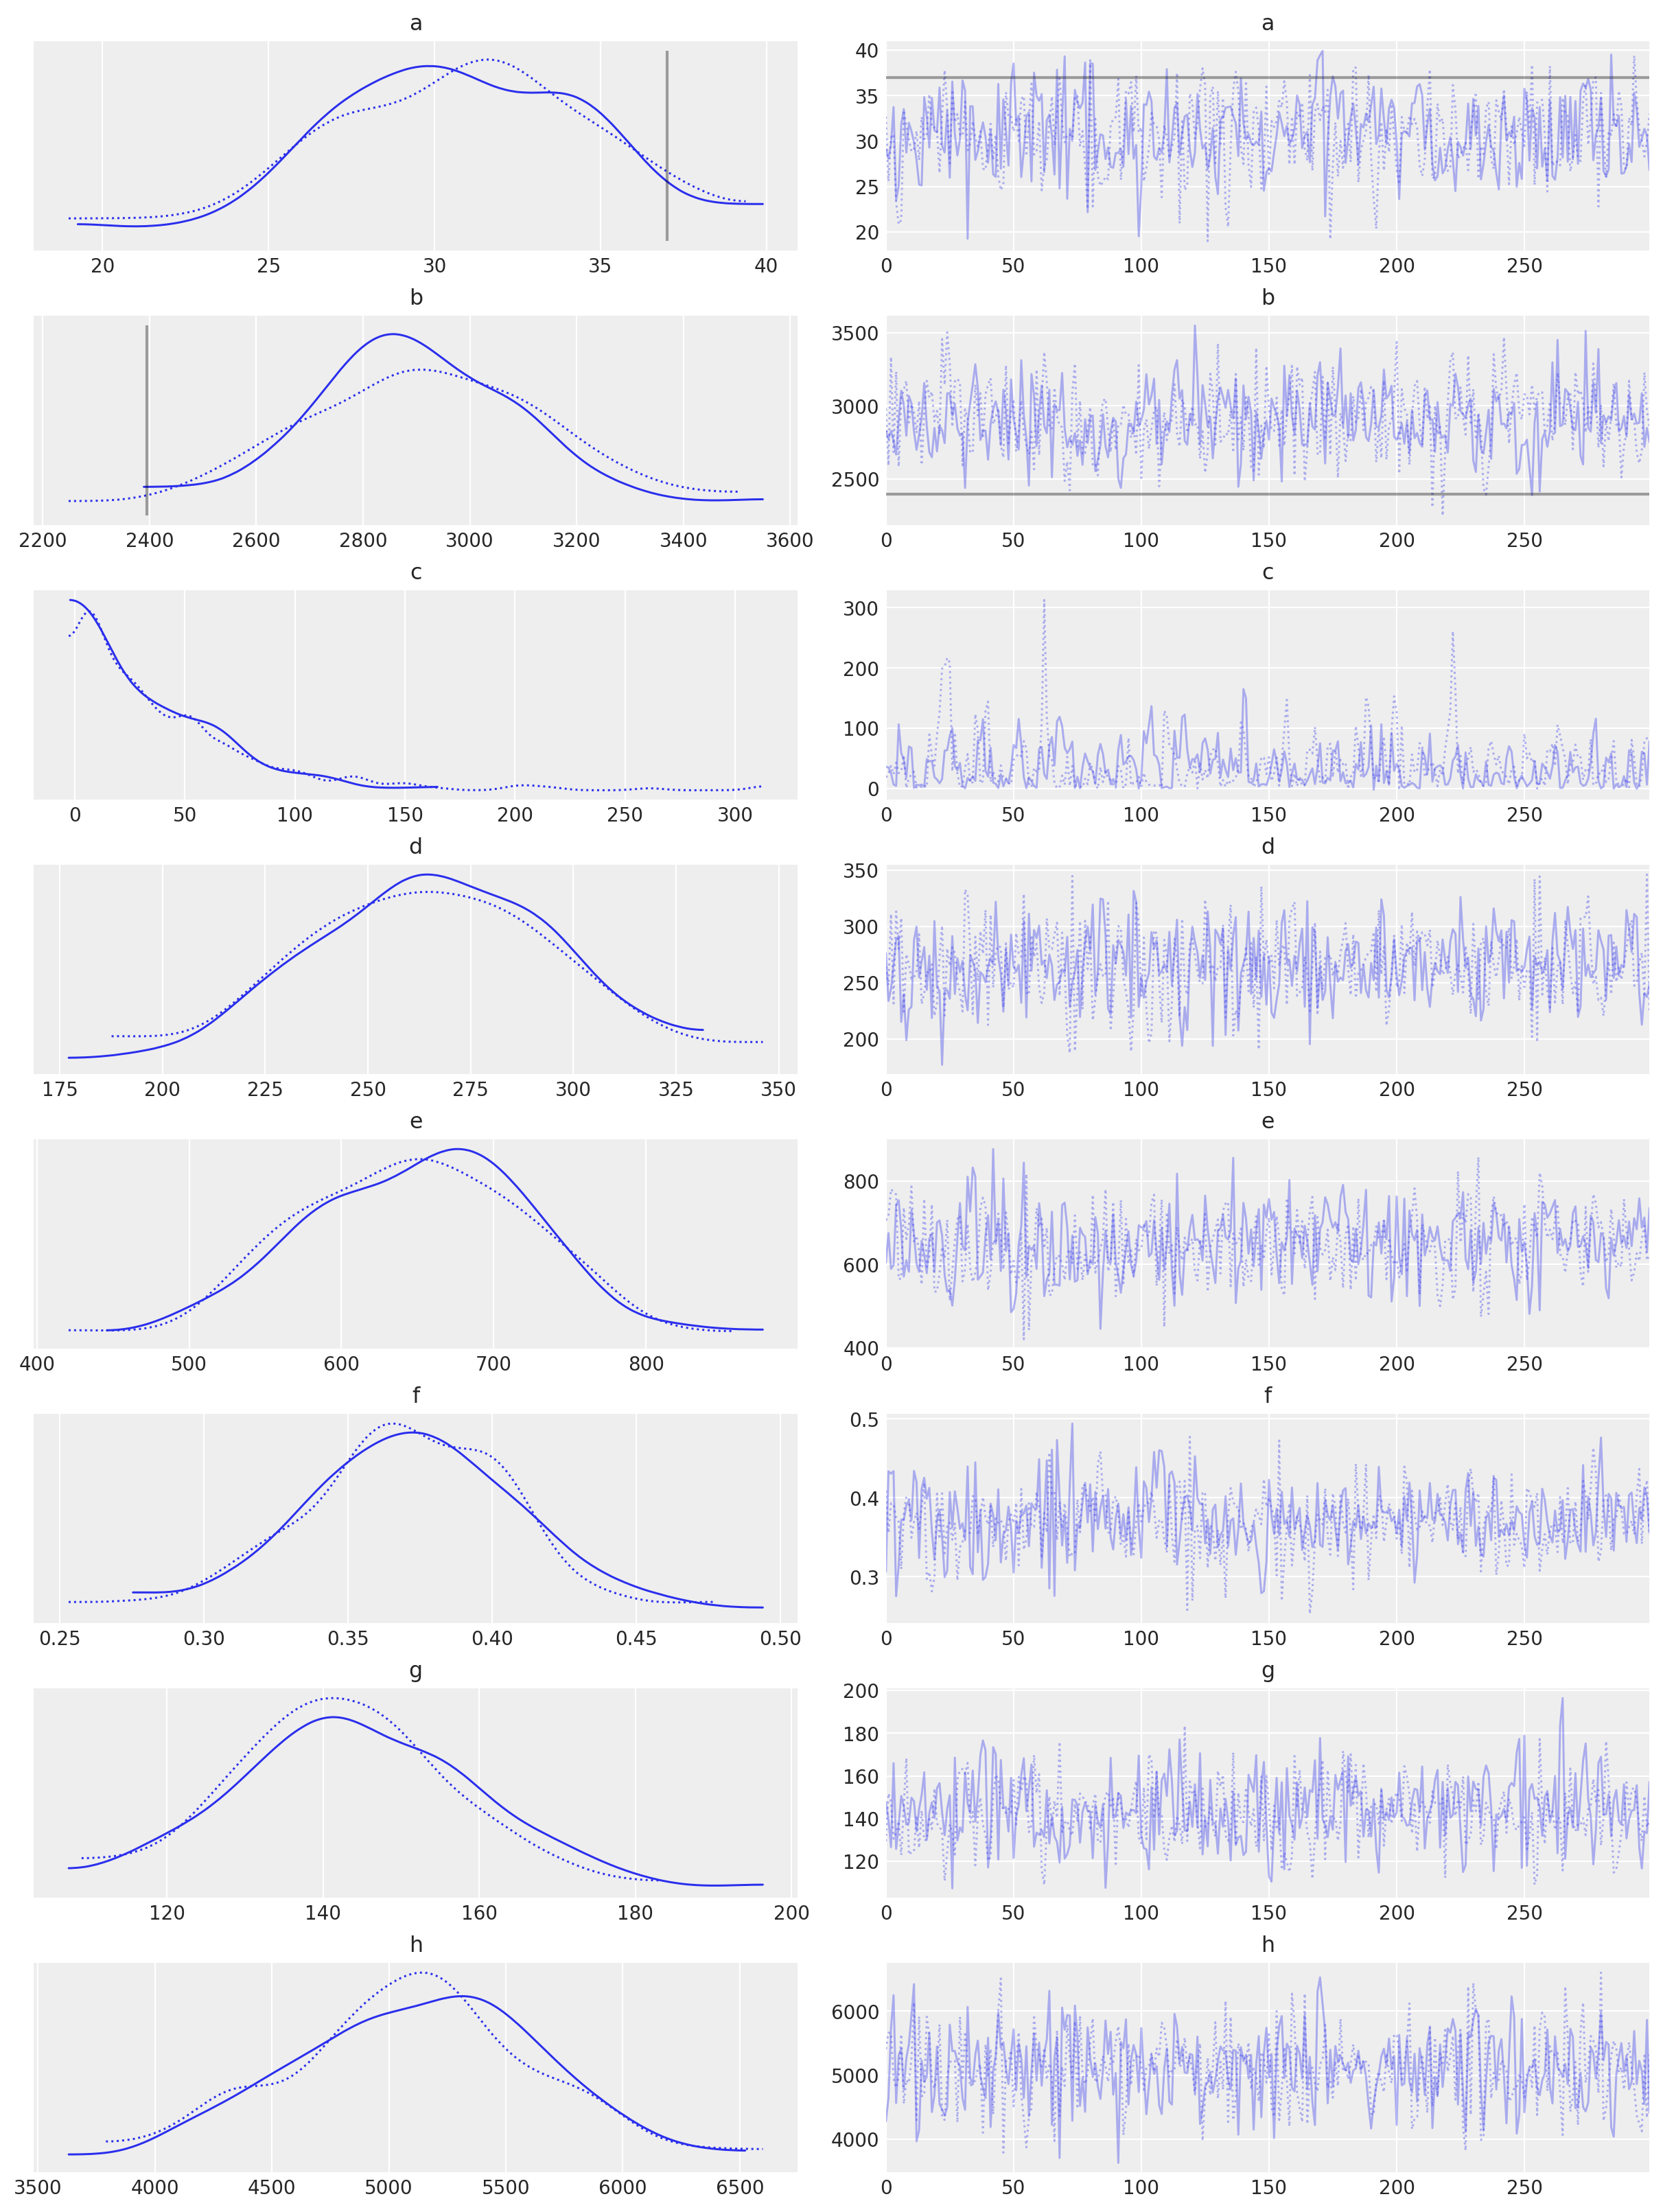

In [7]:
# create our Op
logl = LogLike(my_loglike)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
   # m = pm.Uniform("m", lower=-10.0, upper=10.0)
    #c = pm.Uniform("c", lower=-10.0, upper=10.0)
    
    a1, b1, c1, d1, e1, f1, g1, h1 = 37, 2395, 1856, 286, 811, 0.37, 148, 5144
    
    # Define the priors for the parameters
    a = pm.Normal('a', mu=a1, sigma=a1/10)
    b = pm.Normal('b', mu=b1, sigma=b1/10)
    c = pm.Normal('c', mu=c1, sigma=c1/10)
    d = pm.Normal('d', mu=d1, sigma=d1/10)
    e = pm.Normal('e', mu=e1, sigma=e1/10)
    f = pm.Normal('f', mu=f1, sigma=f1/10)
    g = pm.Normal('g', mu=g1, sigma=g1/10)
    h = pm.Normal('h', mu=h1, sigma=h1/10)    
    

    # convert m and c to a tensor vector
    #theta = pt.as_tensor_variable([m, c])
    theta = pt.as_tensor_variable([a,b,c,d,e,f,g,h])
    
    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(theta))

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(300, tune=100)

# plot the traces
az.plot_trace(idata_mh, lines=[("a", {}, a1), ("b", {}, b1)]);

## PyTensor Op with grad

What if we wanted to use NUTS or HMC? If we knew the analytical derivatives of the model/likelihood function then we could add a [grad() method](http://deeplearning.net/software/pytensor/extending/op.html#grad) to the Op using that analytical form.

But, what if we don't know the analytical form. If our model/likelihood is purely Python and made up of standard maths operators and Numpy functions, then the [autograd](https://github.com/HIPS/autograd) module could potentially be used to find gradients (also, see [here](https://github.com/ActiveState/code/blob/master/recipes/Python/580610_Auto_differentiation/recipe-580610.py) for a nice Python example of automatic differentiation). But, if our model/likelihood truly is a "black box" then we can just use the good-old-fashioned [finite difference](https://en.wikipedia.org/wiki/Finite_difference) to find the gradients - this can be slow, especially if there are a large number of variables, or the model takes a long time to evaluate. Below, a function to find gradients has been defined that uses the finite difference (the central difference) - it uses an iterative method with successively smaller interval sizes to check that the gradient converges. But, you could do something far simpler and just use, for example, the SciPy [approx_fprime](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html) function.

Note that since PyMC 3.11.0, normalization constants are dropped from the computation, thus, we will do the same to ensure both gradients return exactly the same value (which will be checked below). As `sigma=1` in this case the dropped factor is only a factor 2, but for completeness, the term is shown as a comment. Try to see what happens if you uncomment this term and rerun the whole notebook.

In [62]:
def my_model2(theta):
    nC=3
    nO=2
    a,b,c,d,e,f,g,h = theta
    myCano = Canonical(nC,nO)
    return myCano.do_perm(a,b,c,d,e,f,g,h)

def my_loglike(theta, data):
    #model = my_model(theta, x)
    """This calculation won't really deliver what we want
    if my_model2 returns -ve it means there was no canonical.
    so we don't want to square it!  
    if it is negative then it's poor and as it becomes less negative
    its good. So replace:
    -(data-my_model2(theta))**2
    with:
    simply my_model2-data
    noting that of course data is 0... 
    or if smart make this a big number and then it will never be acheived.
    
    """
    return my_model2(theta)-data
    #return -(0.5 / sigma**2) * np.sum((data - model) ** 2)

In [63]:
def normal_gradients(theta, data):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    theta: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    x, data, sigma:
        Observed variables as we have been using so far


    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.empty(8)
    aux_vect = data - my_model2(theta)  # /(2*sigma**2)
    grads[0] = np.sum(aux_vect)
    grads[1] = np.sum(aux_vect)
    grads[2] = np.sum(aux_vect)
    grads[3] = np.sum(aux_vect)
    grads[4] = np.sum(aux_vect)
    grads[5] = np.sum(aux_vect)
    grads[6] = np.sum(aux_vect)
    grads[7] = np.sum(aux_vect)   

    return grads

So, now we can just redefine our Op with a `grad()` method, right?

It's not quite so simple! The `grad()` method itself requires that its inputs are PyTensor tensor variables, whereas our `gradients` function above, like our `my_loglike` function, wants a list of floating point values. So, we need to define another Op that calculates the gradients. Below, I define a new version of the `LogLike` Op, called `LogLikeWithGrad` this time, that has a `grad()` method. This is followed by anothor Op called `LogLikeGrad` that, when called with a vector of PyTensor tensor variables, returns another vector of values that are the gradients (i.e., the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)) of our log-likelihood function at those values. Note that the `grad()` method itself does not return the gradients directly, but instead returns the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)-vector product (you can hopefully just copy what I've done and not worry about what this means too much!).

In [64]:
# define a pytensor Op for our likelihood function
class LogLikeWithGrad(pt.Op):
    itypes = [pt.dvector]  # expects a vector of parameter values when called
    otypes = [pt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data


        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.data)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # this will contain my variables

        # call the log-likelihood function
        logl = self.likelihood(theta, self.data)

        outputs[0][0] = np.array(logl)  # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values
        (theta,) = inputs  # our parameters
        return [g[0] * self.logpgrad(theta)]


class LogLikeGrad(pt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """

    itypes = [pt.dvector]
    otypes = [pt.dvector]

    def __init__(self, data):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.data = data

    def perform(self, node, inputs, outputs):
        (theta,) = inputs

        # calculate gradients
        grads = normal_gradients(theta, self.data)

        outputs[0][0] = grads

Now, let's re-run PyMC with our new "grad"-ed Op. This time it will be able to automatically use NUTS.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, c, d, e, f, g, h]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 34592 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


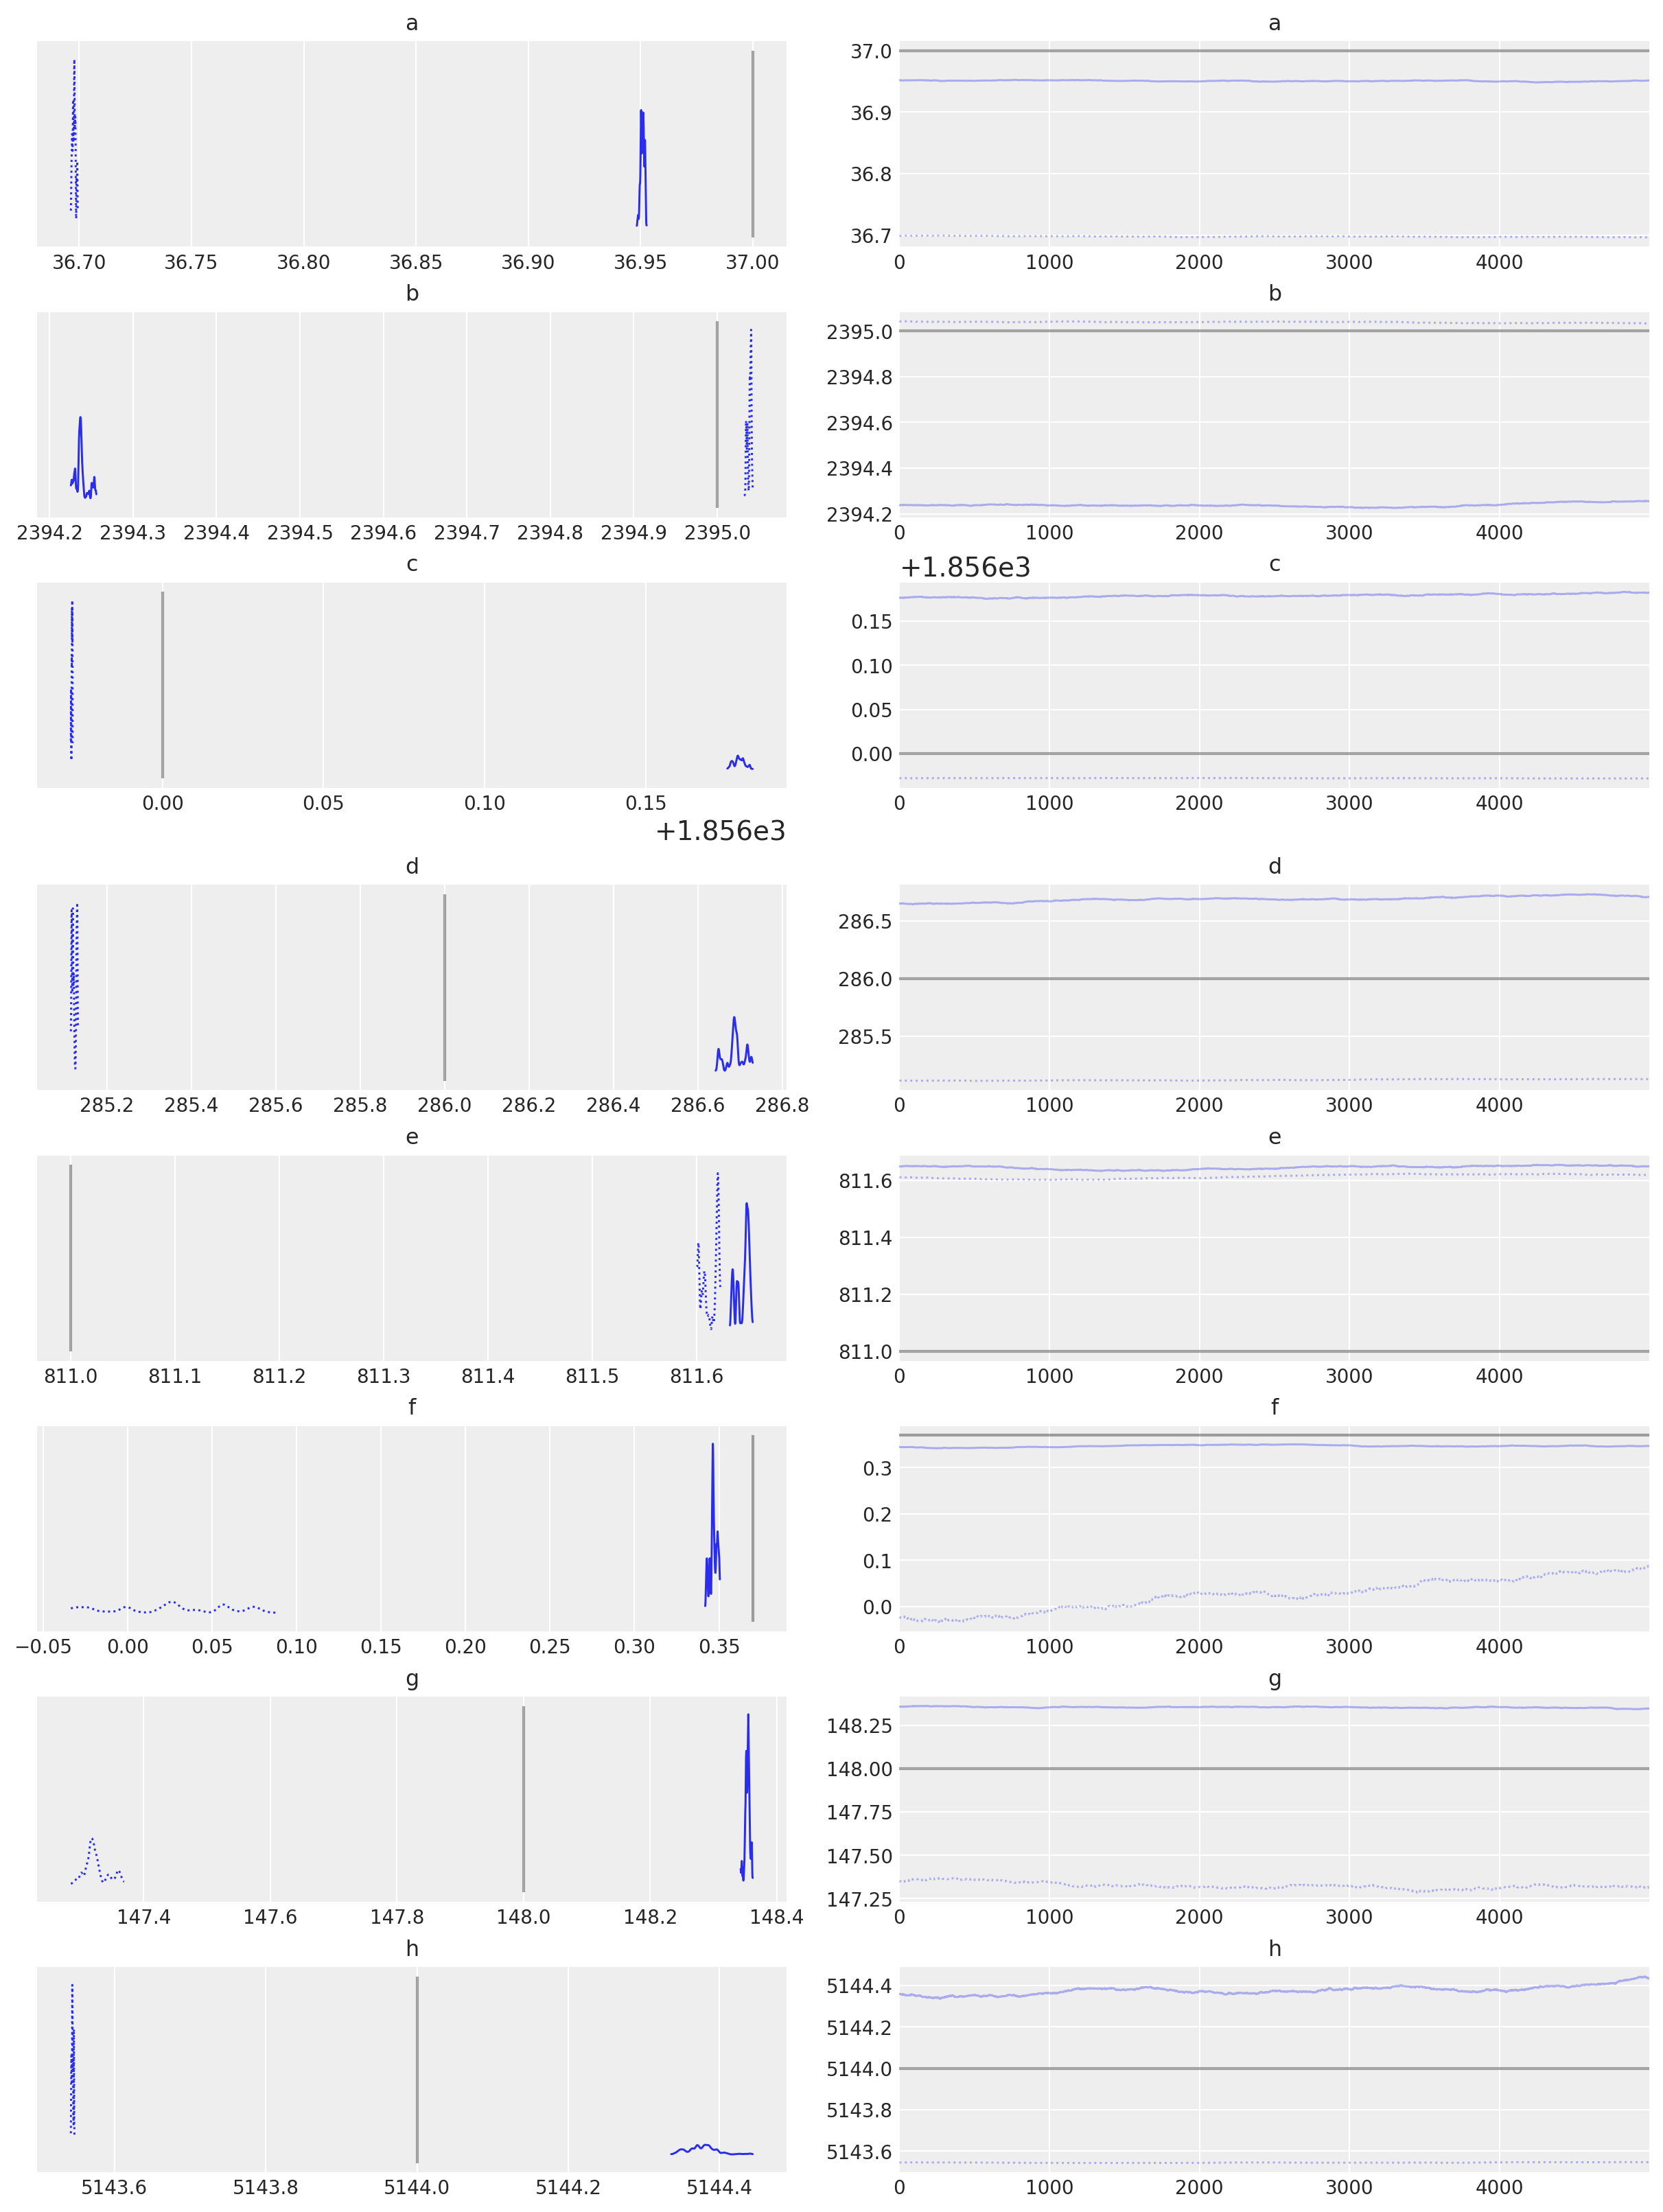

In [65]:
# create our Op
data=0
logl = LogLikeWithGrad(my_loglike, data)

# use PyMC to sampler from log-likelihood
with pm.Model() as opmodel:
    
    a1, b1, c1, d1, e1, f1, g1, h1 = 37, 2395, 1856, 286, 811, 0.37, 148, 5144
    
    # Define the priors for the parameters
    a = pm.Normal('a', mu=a1, sigma=a1/10)
    b = pm.Normal('b', mu=b1, sigma=b1/10)
    c = pm.Normal('c', mu=c1, sigma=c1/10)
    d = pm.Normal('d', mu=d1, sigma=d1/10)
    e = pm.Normal('e', mu=e1, sigma=e1/10)
    f = pm.Normal('f', mu=f1, sigma=f1/10)
    g = pm.Normal('g', mu=g1, sigma=g1/10)
    h = pm.Normal('h', mu=h1, sigma=h1/10)    
    

    # convert m and c to a tensor vector
    #theta = pt.as_tensor_variable([m, c])
    theta = pt.as_tensor_variable([a,b,c,d,e,f,g,h])

    # use a Potential
    pm.Potential("likelihood", logl(theta))

    idata_grad = pm.sample(5000, tune=1000)

# plot the traces
_ = az.plot_trace(idata_grad, lines=[("a", {}, a1), 
                                     ("b", {}, b1), 
                                     ("c", {}, c1),
                                     ("d", {}, d1),
                                     ("e", {}, e1),
                                     ("f", {}, f1),
                                     ("g", {}, g1),
                                     ("h", {}, h1)])

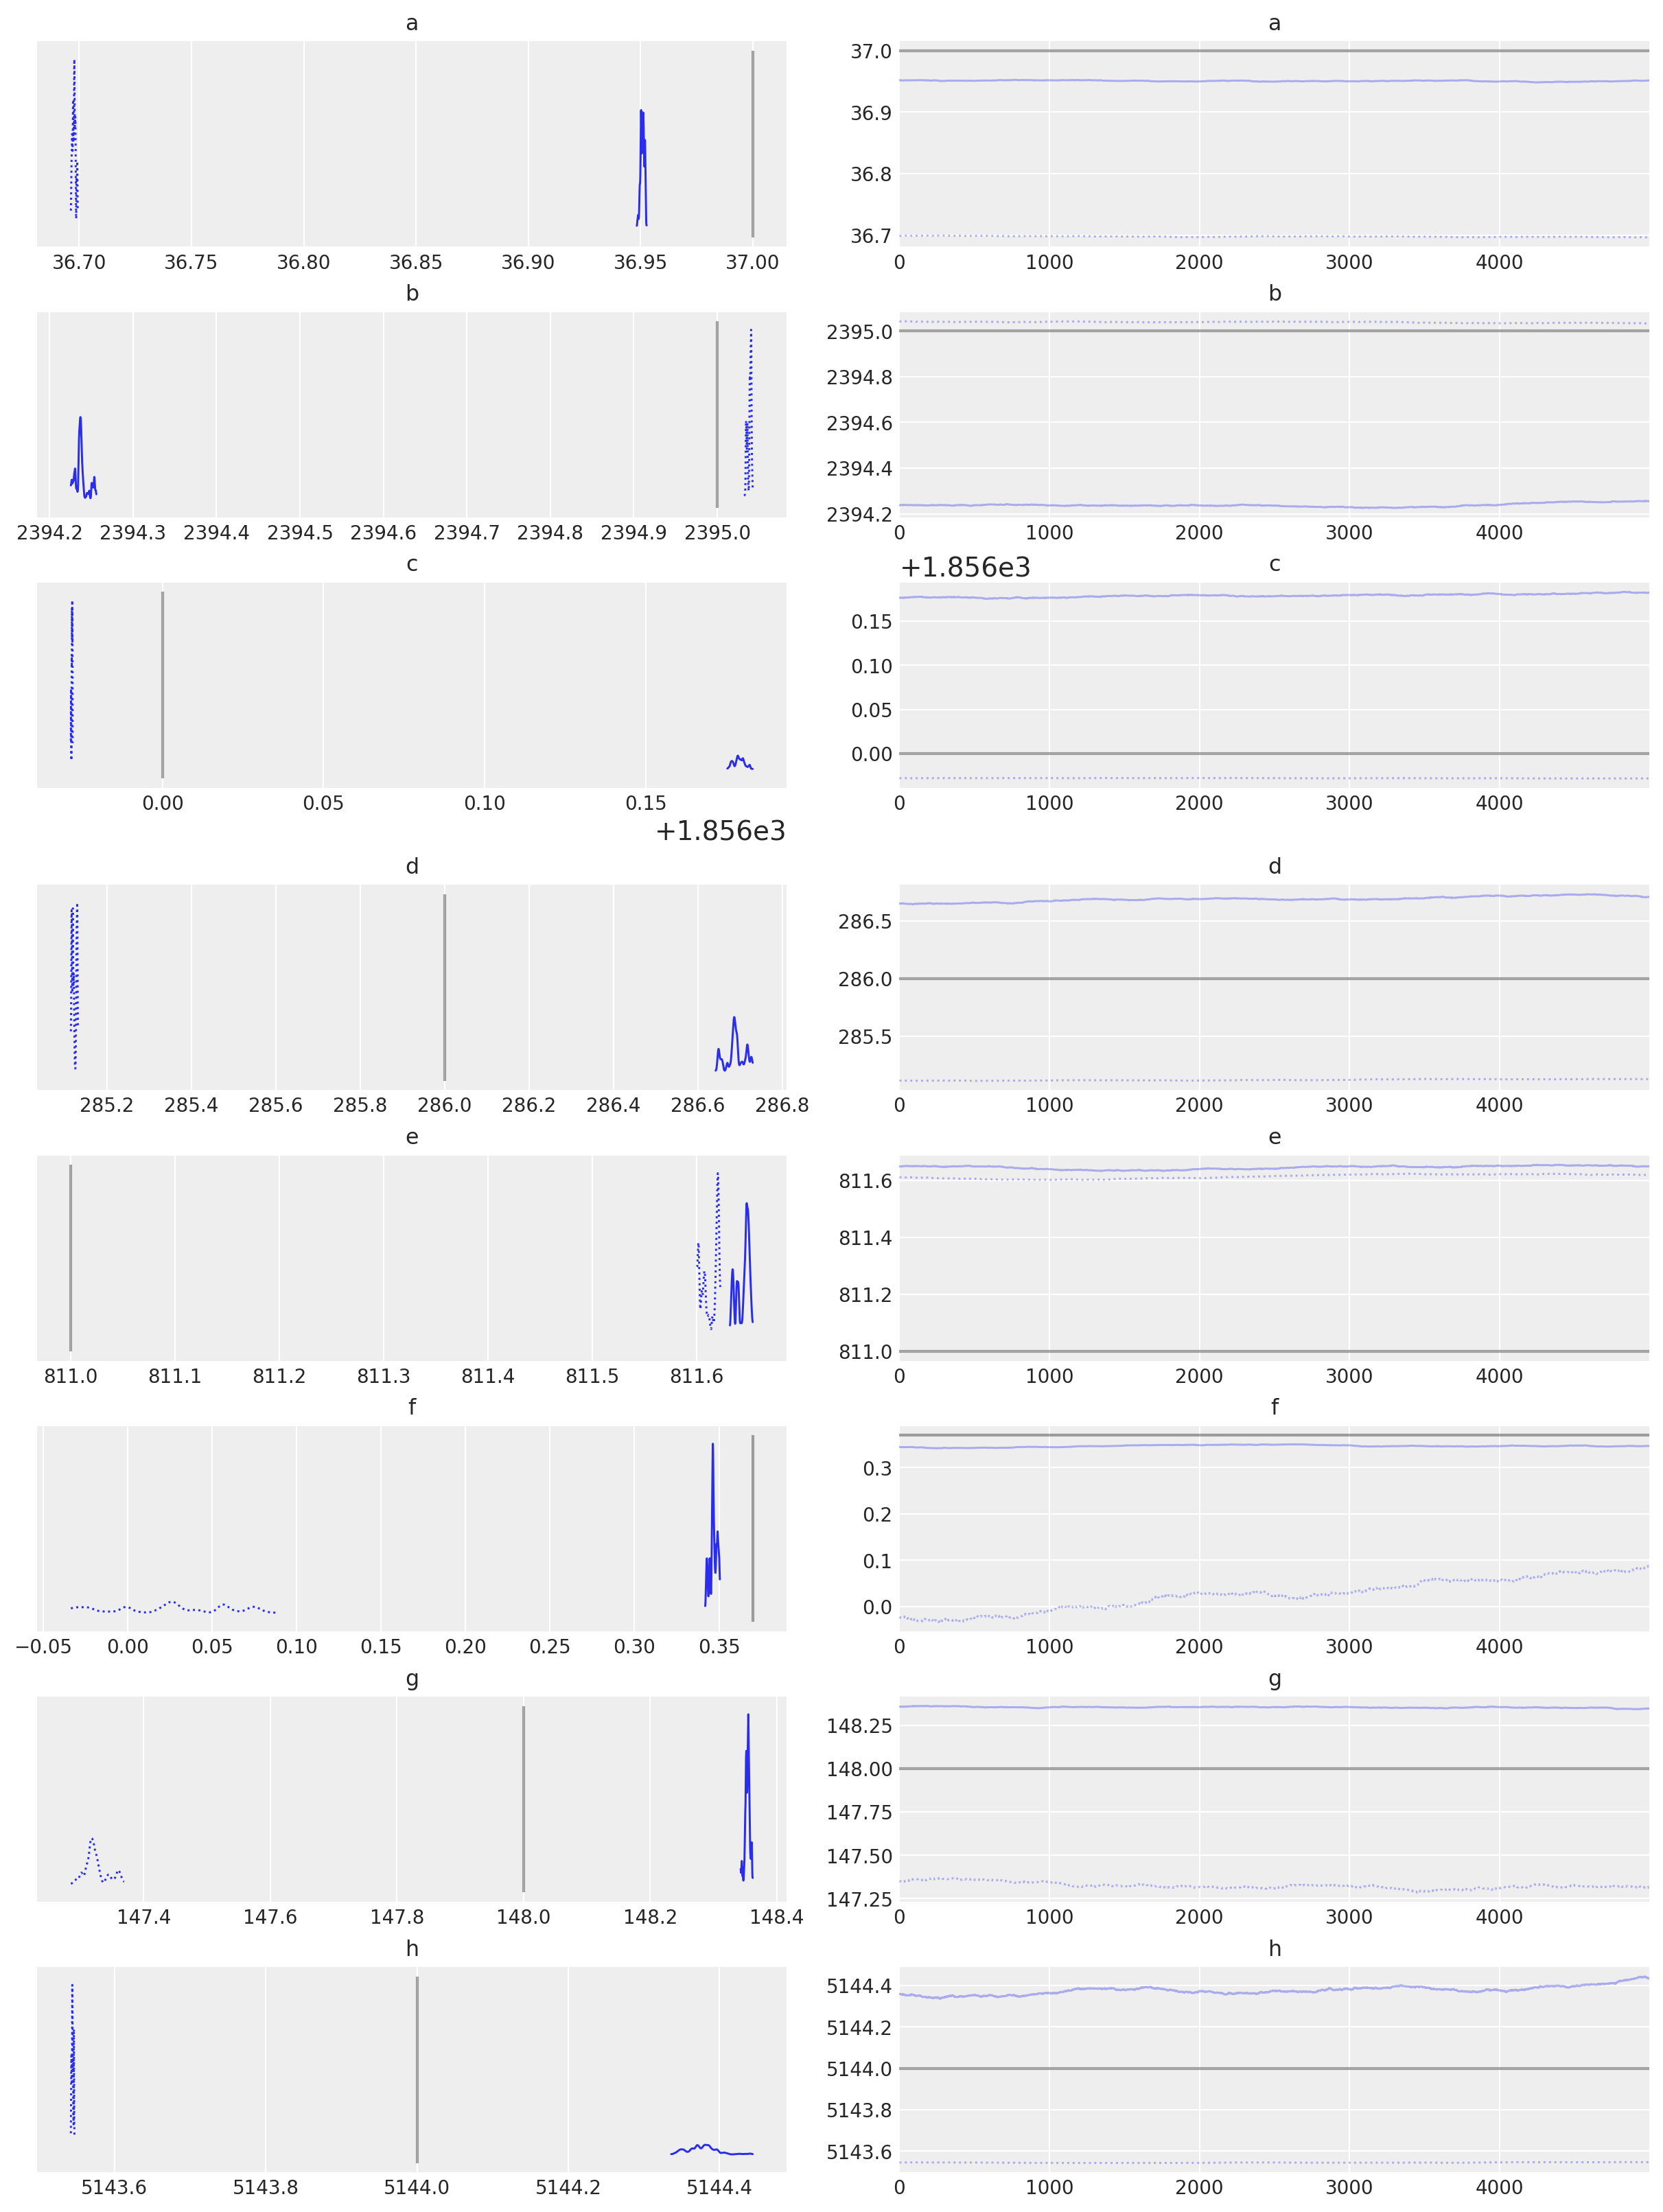

In [66]:
# plot the traces
_ = az.plot_trace(idata_grad, lines=[("a", {}, a1), 
                                     ("b", {}, b1), 
                                     ("c", {}, c1),
                                     ("d", {}, d1),
                                     ("e", {}, e1),
                                     ("f", {}, f1),
                                     ("g", {}, g1),
                                     ("h", {}, h1)])

In [93]:
import pandas as pd
pm.summary(idata_grad).to_csv("first.csv")

res=pm.summary(idata_grad)

In [102]:
res

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,36.824,0.127,36.697,36.952,0.089,0.076,3.0,24.0,2.12
b,2394.638,0.400,2394.229,2395.042,0.283,0.240,3.0,16.0,1.99
c,1856.075,0.104,1855.972,1856.181,0.073,0.062,2.0,11.0,2.77
d,285.906,0.783,285.115,286.718,0.553,0.469,2.0,12.0,2.61
e,811.629,0.017,811.601,811.651,0.012,0.010,2.0,13.0,2.63
f,0.186,0.162,-0.023,0.351,0.114,0.097,3.0,11.0,2.16
g,147.839,0.515,147.307,148.361,0.364,0.308,3.0,17.0,2.07
h,5143.961,0.417,5143.542,5144.397,0.294,0.249,3.0,11.0,2.22


In [101]:
means = res["mean"].values
my_model2(means)

-810.1882200000001

## Comparison to equivalent PyMC distributions
Now, finally, just to check things actually worked as we might expect, let's do the same thing purely using PyMC distributions (because in this simple example we can!)

In [ ]:
with pm.Model() as pymodel:
    # uniform priors on m and c
    m = pm.Uniform("m", lower=-10.0, upper=10.0)
    c = pm.Uniform("c", lower=-10.0, upper=10.0)

    # convert m and c to a tensor vector
    theta = pt.as_tensor_variable([m, c])

    # use a Normal distribution
    y = pm.Normal("likelihood", mu=(m * x + c), sigma=sigma, observed=data)

    idata = pm.sample()

# plot the traces
az.plot_trace(idata, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

To check that they match let's plot all the examples together and also find the autocorrelation lengths.

In [ ]:
_, axes = plt.subplots(3, 2, sharex=True, sharey=True)
az.plot_autocorr(idata_mh, combined=True, ax=axes[0, :])
az.plot_autocorr(idata_grad, combined=True, ax=axes[1, :])
az.plot_autocorr(idata, combined=True, ax=axes[2, :])
axes[2, 0].set_xlim(right=40);

In [ ]:
# Plot MH result (blue)
pair_kwargs = dict(
    kind="kde",
    marginals=True,
    reference_values={"m": mtrue, "c": ctrue},
    kde_kwargs={"contourf_kwargs": {"alpha": 0}, "contour_kwargs": {"colors": "C0"}},
    reference_values_kwargs={"color": "k", "ms": 15, "marker": "d"},
    marginal_kwargs={"color": "C0"},
)
ax = az.plot_pair(idata_mh, **pair_kwargs)

# Plot nuts+blackbox fit (orange)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C1"
pair_kwargs["marginal_kwargs"]["color"] = "C1"
az.plot_pair(idata_grad, **pair_kwargs, ax=ax)

# Plot pure pymc+nuts fit (green)
pair_kwargs["kde_kwargs"]["contour_kwargs"]["colors"] = "C2"
pair_kwargs["marginal_kwargs"]["color"] = "C2"
az.plot_pair(idata, **pair_kwargs, ax=ax);

We can now check that the gradient Op works as expected. First, just create and call the `LogLikeGrad` class, which should return the gradient directly (note that we have to create a [PyTensor function](http://deeplearning.net/software/pytensor/library/compile/function.html) to convert the output of the Op to an array). Secondly, we call the gradient from `LogLikeWithGrad` by using the [PyTensor tensor gradient](http://deeplearning.net/software/pytensor/library/gradient.html#pytensor.gradient.grad) function. Finally, we will check the gradient returned by the PyMC model for a Normal distribution, which should be the same as the log-likelihood function we defined. In all cases we evaluate the gradients at the true values of the model function (the straight line) that was created.

In [ ]:
ip = pymodel.initial_point()
print(f"Evaluating dlogp of model at point\n    {ip}")

grad_vals_custom = opmodel.compile_dlogp()(ip)
grad_vals_pymc = pymodel.compile_dlogp()(ip)

print(f'\nGradient of model using a custom "LogLikeWithGrad":\n    {grad_vals_custom}')
print(f'Gradient of model using a PyMC "Normal" distribution:\n    {grad_vals_pymc}')

We could also do some profiling to compare performance between implementations. The {ref}`profiling` notebook shows how to do it.

## Authors

* Adapted from [Jørgen Midtbø](https://github.com/jorgenem/)'s [example](https://discourse.pymc.io/t/connecting-pymc-to-external-code-help-with-understanding-pytensor-custom-ops/670) by Matt Pitkin both as a [blogpost](http://mattpitkin.github.io/samplers-demo/pages/pymc-blackbox-likelihood/) and as an example notebook to this gallery in August, 2018 ([pymc#3169](https://github.com/pymc-devs/pymc/pull/3169) and [pymc#3177](https://github.com/pymc-devs/pymc/pull/3177))
* Updated by [Oriol Abril](https://github.com/OriolAbril) on December 2021 to drop the Cython dependency from the original notebook and use numpy instead ([pymc-examples#28](https://github.com/pymc-devs/pymc-examples/pull/28))
* Re-executed by Oriol Abril with pymc 5.0.0 ([pymc-examples#496](https://github.com/pymc-devs/pymc-examples/pull/496))

## Watermark

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

:::{include} ../page_footer.md
:::